In [ ]:
import pandas as pd
import os
import glob

# target genes (converted to uppercase for case-insensitive matching)
target_genes = {
    'ACACA', 'ACACB', 'ACLY', 'ACVR2A', 'AKT1', 'ALK', 'APC', 'ARF1', 'ATM', 'ATR', 'AURKA', 'BBC3', 'BRAF', 'BRCA1', 'BRCA2',
    'CAMKK2', 'CCND1', 'CCND2', 'CCNE1', 'CDH1', 'CDK2', 'CDK4', 'CDK6', 'CDKN1A', 'CDKN1B', 'CDKN2A', 'CDKN2B', 'CDKN2C',
    'CHEK1', 'CHEK2', 'CREBBP', 'CSF1R', 'CSF2RA', 'CTNNB1', 'DAAM1', 'DAAM2', 'DVL2', 'DVL3', 'E2F1', 'EGFR', 'EGLN2',
    'EIF4E', 'EIF4EBP1', 'ERBB2', 'ESRRA', 'FBXW7', 'FGFR1', 'FOXO3', 'GLS2', 'GSK3B', 'HIF1A', 'HK2', 'HMGCR', 'ID2',
    'IGF1R', 'IKBKB', 'IL1R1', 'JAK1', 'JUB', 'JUN', 'KDR', 'KEAP1', 'KIT', 'KRAS', 'LATS1', 'LATS2', 'LDHA', 'MAP2K1',
    'MAP2K3', 'MAP3K7', 'MAPK1', 'MAPK14', 'MAPK8', 'MDM2', 'MDM4', 'MET', 'MST1', 'MTOR', 'MYC', 'NDRG3', 'NF1', 'NF2',
    'NFE2L2', 'NFKB1', 'NOTCH1', 'PDGFRA', 'PDHA1', 'PDK1', 'PFKM', 'PIK3CA', 'PPARA', 'PPARGC1A', 'PRKAA2', 'PTEN',
    'RAF1', 'RB1', 'RET', 'RHEB', 'RHOA', 'RPS6KB1', 'SETD2', 'SLC16A1', 'SLC2A1', 'SMAD3', 'SMAD4', 'SOX4', 'SOX17',
    'SOX9', 'SREBF1', 'STAT3', 'STAT5A', 'STK11', 'STK3', 'TAZ', 'TGFBR2', 'TLR1', 'TNFRSF1A', 'TP53', 'TRAF4', 'TSC1',
    'TSC2', 'ULK1', 'VHL', 'YAP1', 'ZHX2'
}


# Directory containing the files
data_dir = '/content/sample_data'

# Get all mutation files dynamically
mutation_files = glob.glob(os.path.join(data_dir, '*_combined_profile.csv'))

# List to store mutation dataframes
mutation_dfs = []

# Possible gene column names
gene_col_aliases = [' gene', ' Gene', 'Hugo_Symbol', 'hugo_symbol']

for file in mutation_files:
    try:
        cancer_type = os.path.basename(file).split('_')[0]
        df = pd.read_csv(file)

        # Find gene column
        gene_col = next((col for col in gene_col_aliases if col in df.columns), None)

        if not gene_col:
            print(f"Skipping {file}: No gene column found")
            continue

        # Standardize column names
        df = df.rename(columns={
            gene_col: ' gene',
            'patient_id': 'bcr_patient_barcode'
        })

        # Filter for target genes
        df_filtered = df[df[' gene'].str.upper().isin(target_genes)]

        if df_filtered.empty:
            print(f"Skipping {file}: No target genes found")
            continue

        df_filtered['cancer_type'] = cancer_type
        mutation_dfs.append(df_filtered)

    except Exception as e:
        print(f"Error processing {file}: {str(e)}")
        continue

if not mutation_dfs:
    raise ValueError("No mutation data found for target genes")

combined_mutations = pd.concat(mutation_dfs, ignore_index=True)

# Load and clean survival data
survival_data = pd.read_csv('/content/sample_data/survival_data.csv').replace('#N/A', pd.NA)

# Merge data
merged_data = pd.merge(
    combined_mutations,
    survival_data,
    on='bcr_patient_barcode',
    how='inner',
    validate='m:1'
)

# Save relevant columns
final_cols = [
    'bcr_patient_barcode', 'cancer_type', ' gene', 'mutation',
    'PFI.1', 'PFI.time.1', 'DSS_cr', 'DSS.time.cr'
]

merged_data[final_cols].to_csv('filtered_gene_data.csv', index=False)
print("Filtered data saved successfully!")

<ipython-input-4-e3dd1452f166>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['cancer_type'] = cancer_type
<ipython-input-4-e3dd1452f166>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['cancer_type'] = cancer_type
<ipython-input-4-e3dd1452f166>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Filtered data saved successfully!


In [ ]:
# After saving, check the results
df = pd.read_csv('filtered_gene_data.csv')
print(f"Unique genes found: {df[' gene'].unique()}")
print(f"Total entries: {len(df)}")
print(f"Patients with mutations: {df['bcr_patient_barcode'].nunique()}")

Unique genes found: ['BRAF' 'DVL2' 'TRAF4' 'DAAM1' 'ATM' 'BRCA2' 'SETD2' 'EGFR' 'LDHA' 'PTEN'
 'TP53' 'ID2' 'JUN' 'MAP2K1' 'IGF1R' 'PIK3CA' 'KRAS' 'MST1' 'ATR' 'CDKN2A'
 'PPARA' 'IL1R1' 'CDKN1A' 'FBXW7' 'CHEK2' 'RAF1' 'RB1' 'CTNNB1' 'KIT'
 'ALK' 'JAK1' 'KEAP1' 'APC' 'CDKN1B' 'AKT1' 'DVL3' 'ACVR2A' 'PPARGC1A'
 'MET' 'CSF2RA' 'SLC2A1' 'LATS1' 'CREBBP' 'CAMKK2' 'CDKN2C' 'NF1' 'RET'
 'BRCA1' 'KDR' 'ACACB' 'FGFR1' 'STAT5A' 'TGFBR2' 'HIF1A' 'HMGCR' 'HK2'
 'CDH1' 'AURKA' 'DAAM2' 'TAZ' 'MDM2' 'NDRG3' 'ULK1' 'PDGFRA' 'MAPK1'
 'RPS6KB1' 'CSF1R' 'NFKB1' 'STK11' 'TSC1' 'NOTCH1' 'ACLY' 'MAP3K7'
 'TNFRSF1A' 'NF2' 'SOX9' 'IKBKB' 'TSC2' 'SMAD4' 'NFE2L2' 'RHOA' 'SREBF1'
 'MTOR' 'STAT3' 'TLR1' 'CCNE1' 'MYC' 'PRKAA2' 'RHEB' 'SMAD3' 'ESRRA'
 'MDM4' 'LATS2' 'ERBB2' 'ACACA' 'ZHX2' 'MAPK8' 'PFKM' 'CDK4' 'STK3'
 'FOXO3' 'MAP2K3' 'EIF4EBP1' 'SLC16A1' 'SOX17' 'GSK3B' 'CCND1' 'VHL'
 'ARF1' 'PDK1' 'CHEK1' 'MAPK14' 'PDHA1' 'EGLN2' 'YAP1' 'GLS2' 'E2F1'
 'EIF4E' 'CCND2' 'SOX4' 'CDK2' 'CDKN2B' 'BBC3' 'CDK6']
Total en

In [ ]:
# Load the merged data
df = pd.read_csv('/content/filtered_gene_data.csv')

# Basic summary
print(f"Total entries: {len(df)}")
print(f"Unique patients: {df['bcr_patient_barcode'].nunique()}")
print(f"Cancer types: {df['cancer_type'].unique()}")
print(f"Mutation types: {df['mutation'].unique()}")

# Gene frequency analysis
gene_counts = df[' gene'].value_counts().reset_index()
gene_counts.columns = ['Gene', 'Count']
print("\nTop 20 mutated genes:")
print(gene_counts.head(20))

# Cancer type distribution
cancer_dist = df['cancer_type'].value_counts(normalize=True) * 100
print("\nCancer type distribution (%):")
print(cancer_dist)

Total entries: 34404
Unique patients: 7907
Cancer types: ['THCA' 'ACC' 'HNSC' 'ESCA' 'LGG' 'SARC' 'CESC' 'KIRC' 'SKCM' 'UCS' 'BRCA'
 'TGCT' 'UVM' 'OV' 'MESO' 'CHOL' 'BLCA' 'PRAD' 'PCPG' 'LUSC' 'LUAD' 'GBM'
 'THYM' 'LIHC' 'STAD' 'UCEC' 'READ' 'PAAD' 'KICH' 'DLBC' 'KIRP' 'COAD']
Mutation types: ['Missense_Mutation' 'Nonsense_Mutation' 'Frame_Shift_Del' 'In_Frame_Del'
 'Silent' "3'UTR" 'In_Frame_Ins' 'Splice_Site' 'Frame_Shift_Ins'
 'Splice_Region' 'Translation_Start_Site' 'Intron' "5'UTR"
 'Nonstop_Mutation' 'dna' 'Unknown' 'RNA' "3'Flank"]

Top 20 mutated genes:
      Gene  Count
0     TP53   4243
1   PIK3CA   1637
2      APC   1273
3     PTEN   1173
4      NF1    854
5     KRAS    841
6     BRAF    756
7      ATM    737
8    BRCA2    683
9   CREBBP    665
10  NOTCH1    614
11   FBXW7    543
12   ACACB    538
13   SETD2    529
14    EGFR    525
15     ATR    507
16     RB1    500
17  CTNNB1    486
18    MTOR    485
19     KDR    447

Cancer type distribution (%):
cancer_type
UCEC    22.

In [ ]:
# Clean up column names
df = df.rename(columns={' gene': 'gene'})

# Convert survival times to numeric and handle missing values
survival_cols = ['PFI.time.1', 'DSS.time.cr']
df[survival_cols] = df[survival_cols].apply(pd.to_numeric, errors='coerce')

# Create binary survival indicators
df['PFI_status'] = df['PFI.1'].map({0: 0, 1: 1})
df['DSS_status'] = df['DSS_cr'].map({0: 0, 1: 1})

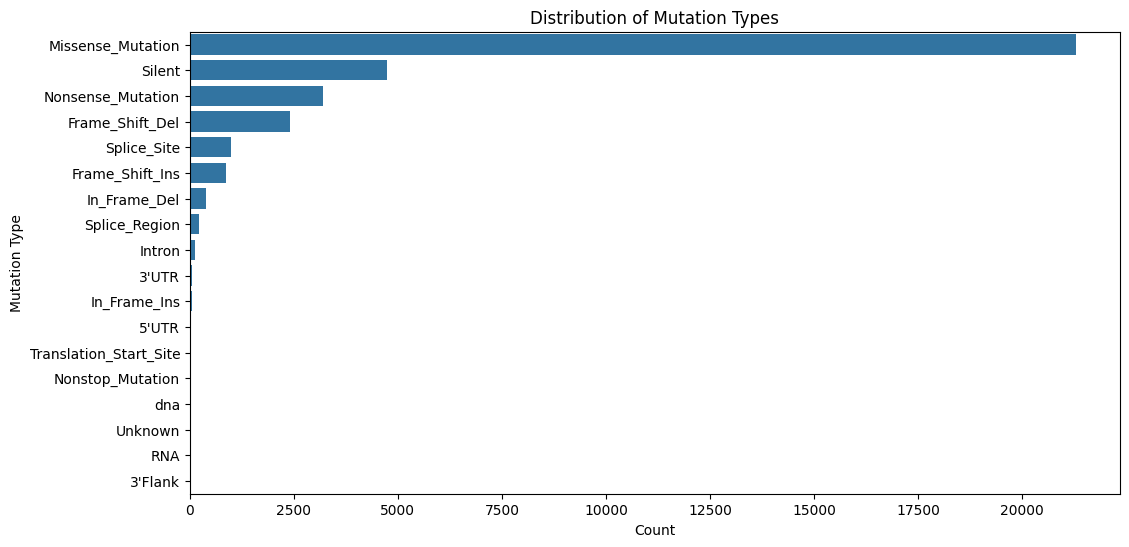


TP53 Mutation Impact:
Patients with TP53 mutations: 3849
5-year PFI rates:
col_0       count
PFI_status       
0.0          2561
1.0          1682
5-year DSS rates:
col_0       count
DSS_status       
0.0          2645
1.0          1104


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot mutation types distribution
plt.figure(figsize=(12, 6))
sns.countplot(y='mutation', data=df, order=df['mutation'].value_counts().index)
plt.title('Distribution of Mutation Types')
plt.xlabel('Count')
plt.ylabel('Mutation Type')
plt.show()

# Survival analysis by gene (example for TP53)
tp53_df = df[df['gene'] == 'TP53']
control_df = df[df['gene'] != 'TP53']

print("\nTP53 Mutation Impact:")
print(f"Patients with TP53 mutations: {tp53_df['bcr_patient_barcode'].nunique()}")
print("5-year PFI rates:")
print(pd.crosstab(tp53_df['PFI_status'], columns='count'))
print("5-year DSS rates:")
print(pd.crosstab(tp53_df['DSS_status'], columns='count'))

In [ ]:
# Define mutation types from  list
mutation_types = [
    'Missense_Mutation', 'Silent', 'Nonsense_Mutation', 'Frame_Shift_Del',
    'Splice_Site', 'Frame_Shift_Ins', 'In_Frame_Del', 'Splice_Region',
    'Intron', 'In_Frame_Ins', "3'UTR", "5'UTR", 'Translation_Start_Site',
    'Nonstop_Mutation', 'dna', 'Unknown', "3'Flank", 'RNA'
]

# Create a dictionary to store results
results = {}

# Clean survival data
df_clean = df.dropna(subset=['PFI.time.1', 'PFI_status', 'DSS.time.cr', 'DSS_status'])

for mutation in mutation_types:
    try:
        # Filter for current mutation type
        mut_df = df_clean[df_clean['mutation'] == mutation]
        control_df = df_clean[df_clean['mutation'] != mutation]

        if len(mut_df) < 5:  # Minimum sample threshold
            continue

        # Calculate PFI rates
        pfi_mut = mut_df['PFI_status'].value_counts(normalize=True).get(1, 0)
        pfi_control = control_df['PFI_status'].value_counts(normalize=True).get(1, 0)

        # Calculate DSS rates
        dss_mut = mut_df['DSS_status'].value_counts(normalize=True).get(1, 0)
        dss_control = control_df['DSS_status'].value_counts(normalize=True).get(1, 0)

        # Store results
        results[mutation] = {
            'Patients_with_mutation': len(mut_df['bcr_patient_barcode'].unique()),
            'PFI_rate_mutation': pfi_mut,
            'PFI_rate_control': pfi_control,
            'DSS_rate_mutation': dss_mut,
            'DSS_rate_control': dss_control,
            'PFI_risk_ratio': pfi_mut / pfi_control if pfi_control != 0 else np.nan,
            'DSS_risk_ratio': dss_mut / dss_control if dss_control != 0 else np.nan
        }

    except Exception as e:
        print(f"Error processing {mutation}: {str(e)}")
        continue

# Convert results to DataFrame
results_df = pd.DataFrame.from_dict(results, orient='index')

# Filter and sort results
significant_results = results_df[
    (results_df['Patients_with_mutation'] >= 10) &
    (results_df['PFI_risk_ratio'] > 1.2)
].sort_values('PFI_risk_ratio', ascending=False)

# Display top results
print("Top mutations impacting survival:")
print(significant_results[['Patients_with_mutation', 'PFI_risk_ratio', 'DSS_risk_ratio']].head(10))

#  Save full results
results_df.to_csv('mutation_type_survival_analysis.csv')

Top mutations impacting survival:
                        Patients_with_mutation  PFI_risk_ratio  DSS_risk_ratio
Translation_Start_Site                      17        1.432263        1.336975
Nonstop_Mutation                            15        1.288894        1.925730
Splice_Site                                769        1.242069        1.246257
In_Frame_Ins                                45        1.217502        1.283774


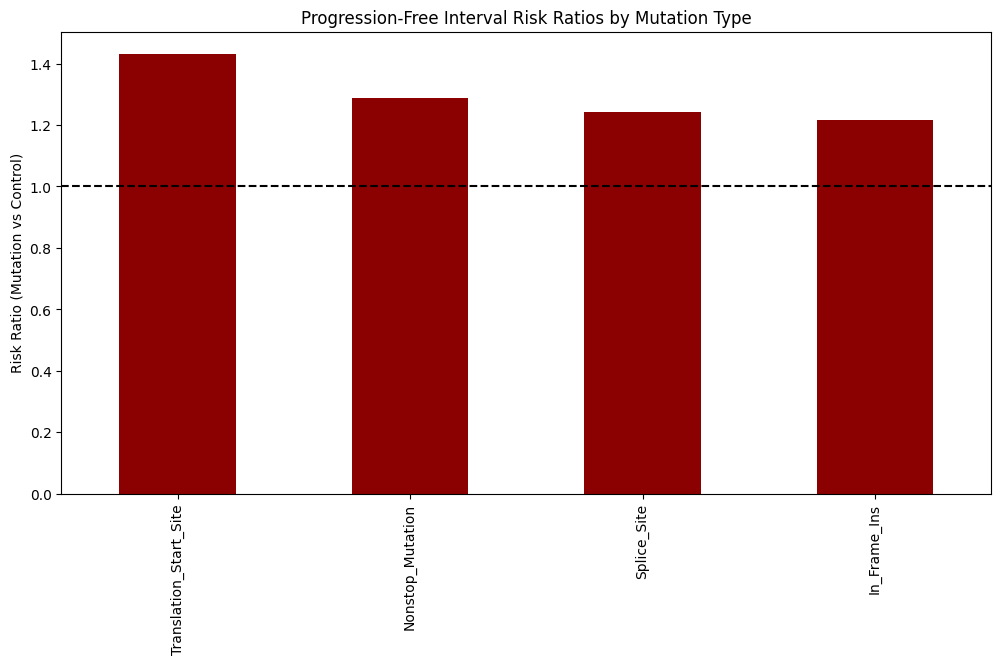

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
significant_results['PFI_risk_ratio'].plot(kind='bar', color='darkred')
plt.title('Progression-Free Interval Risk Ratios by Mutation Type')
plt.ylabel('Risk Ratio (Mutation vs Control)')
plt.axhline(1, color='black', linestyle='--')
plt.show()

In [ ]:
print(df[['PFI.time.1', 'PFI_status']].isnull().sum())


PFI.time.1    175
PFI_status     20
dtype: int64


In [ ]:
!pip install lifelines

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 12.4 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=6f5238254d5d3720837ba31afae9c4737b753fd5344293884af8dfbf8a0f68f4
  Stored in directory: /root/.cache/pip/wheels/8b/67/f4/2caaae2146198dcb824f31a303833b07b14a5ec863fb3acd7b
Successfully built autograd-gamma


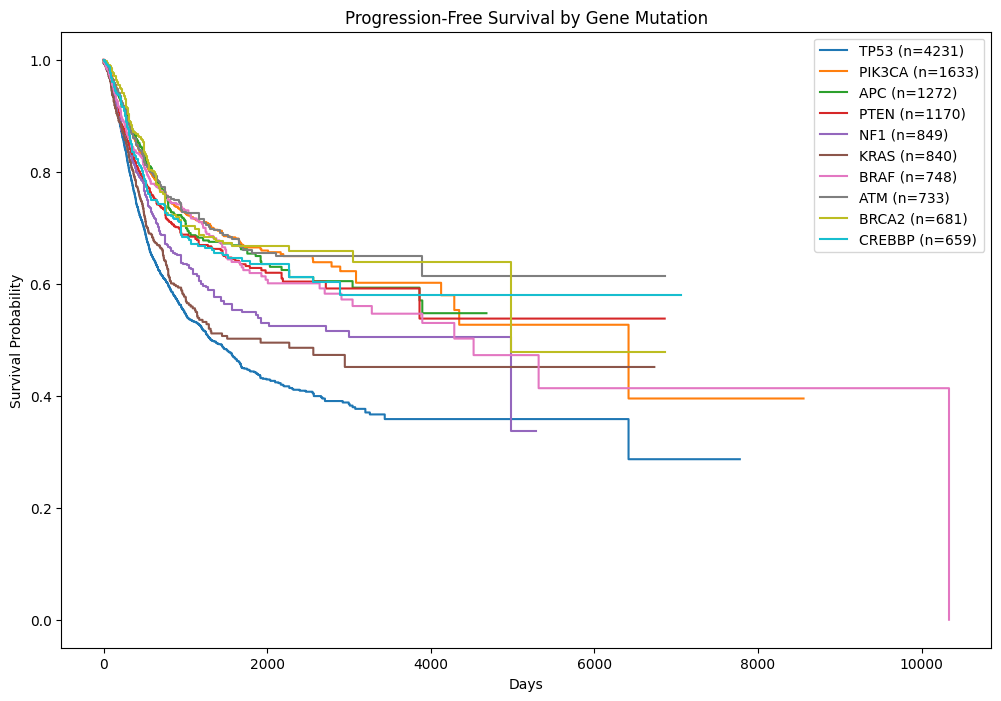


Missing Data Report:
Original rows: 34404
Rows after cleaning: 34229
Percentage retained: 99.5%


In [ ]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

# Clean survival data
df_clean = df.dropna(subset=['PFI.time.1', 'PFI_status']).copy()

# Convert to numeric types
df_clean['PFI.time.1'] = pd.to_numeric(df_clean['PFI.time.1'], errors='coerce')
df_clean['PFI_status'] = pd.to_numeric(df_clean['PFI_status'], errors='coerce')

# Remove any remaining missing values
df_clean = df_clean.dropna(subset=['PFI.time.1', 'PFI_status'])

# Create analysis-ready dataset
analysis_df = df_clean[['gene', 'PFI.time.1', 'PFI_status']].copy()

# Initialize KaplanMeierFitter
kmf = KaplanMeierFitter()

plt.figure(figsize=(12, 8))

# Plot settings
MAX_GROUPS = 10  # Limit number of curves for readability
MIN_SAMPLE_SIZE = 50  # Minimum mutations per gene to include

# Get top mutated genes
top_genes = analysis_df['gene'].value_counts().head(MAX_GROUPS).index

for gene in top_genes:
    gene_data = analysis_df[analysis_df['gene'] == gene]
    if len(gene_data) >= MIN_SAMPLE_SIZE:
        kmf.fit(
            durations=gene_data['PFI.time.1'],
            event_observed=gene_data['PFI_status'],
            label=f"{gene} (n={len(gene_data)})"
        )
        kmf.plot_survival_function(ci_show=False)

plt.title('Progression-Free Survival by Gene Mutation')
plt.xlabel('Days')
plt.ylabel('Survival Probability')
plt.legend()
plt.show()

# Show missing data statistics
print("\nMissing Data Report:")
print(f"Original rows: {len(df)}")
print(f"Rows after cleaning: {len(df_clean)}")
print(f"Percentage retained: {len(df_clean)/len(df)*100:.1f}%")

##DataTransformations

In [ ]:
import pandas as pd

file_path = '/content/filtered_gene_data.csv'  # Update the path if needed
df = pd.read_csv(file_path)

# Display the first few rows to check if the file is read correctly
print("First 5 rows of the dataset:")
print(df.head())

# Select relevant columns to check for null values
cols_to_check = ['mutation', 'PFI.1', 'PFI.time.1', 'DSS_cr', 'DSS.time.cr']

# Count null values in each column
null_counts = df[cols_to_check].isnull().sum()

# Display the result
print("\nNull values in selected columns:")
print(null_counts)

df_nulls = df[df[cols_to_check].isnull().any(axis=1)]
print("\nRows with missing values:")
print(df_nulls)


First 5 rows of the dataset:
  bcr_patient_barcode cancer_type   gene           mutation  PFI.1  \
0        TCGA-H2-A26U        THCA   BRAF  Missense_Mutation    0.0   
1        TCGA-IM-A4EB        THCA   BRAF  Missense_Mutation    0.0   
2        TCGA-IM-A4EB        THCA   DVL2  Missense_Mutation    0.0   
3        TCGA-ET-A25G        THCA   BRAF  Missense_Mutation    0.0   
4        TCGA-DJ-A13U        THCA  TRAF4  Missense_Mutation    0.0   

   PFI.time.1  DSS_cr  DSS.time.cr  
0       517.0     0.0        517.0  
1       780.0     0.0        780.0  
2       780.0     0.0        780.0  
3      2492.0     0.0       2492.0  
4      1590.0     0.0       1590.0  

Null values in selected columns:
mutation          0
PFI.1            20
PFI.time.1      175
DSS_cr         1164
DSS.time.cr     182
dtype: int64

Rows with missing values:
      bcr_patient_barcode cancer_type    gene           mutation  PFI.1  \
148          TCGA-EL-A3CM        THCA    BRAF  Missense_Mutation    0.0   
183 

In [ ]:
# Drop rows with missing values in the selected columns
df_clean = df.dropna(subset=['PFI.1', 'PFI.time.1', 'DSS_cr', 'DSS.time.cr'])

# Display the number of remaining rows
print(f"Original dataset size: {df.shape[0]}")
print(f"Cleaned dataset size: {df_clean.shape[0]}")

# Save the cleaned dataset
df_clean.to_csv('filtered_gene_data_cleaned.csv', index=False)

# Display the first few rows of the cleaned dataset
print("\nFirst 5 rows of the cleaned dataset:")
print(df_clean.head())


Original dataset size: 34404
Cleaned dataset size: 33079

First 5 rows of the cleaned dataset:
  bcr_patient_barcode cancer_type   gene           mutation  PFI.1  \
0        TCGA-H2-A26U        THCA   BRAF  Missense_Mutation    0.0   
1        TCGA-IM-A4EB        THCA   BRAF  Missense_Mutation    0.0   
2        TCGA-IM-A4EB        THCA   DVL2  Missense_Mutation    0.0   
3        TCGA-ET-A25G        THCA   BRAF  Missense_Mutation    0.0   
4        TCGA-DJ-A13U        THCA  TRAF4  Missense_Mutation    0.0   

   PFI.time.1  DSS_cr  DSS.time.cr  
0       517.0     0.0        517.0  
1       780.0     0.0        780.0  
2       780.0     0.0        780.0  
3      2492.0     0.0       2492.0  
4      1590.0     0.0       1590.0  


In [ ]:
import pandas as pd

df_clean = pd.read_csv("/content/filtered_gene_data_cleaned.csv")

# Step 1: Create a pivot table where genes are columns
df_pivot = df_clean.pivot_table(index='bcr_patient_barcode',
                                columns=' gene',
                                values='mutation',
                                aggfunc=lambda x: ', '.join(x))  # If multiple mutations exist, join them

# Step 2: Replace NaN values (genes that don’t have mutations) with "Silent"
df_pivot.fillna("None", inplace=True)

# Step 3: Merge with patient information
df_final = df_clean[['bcr_patient_barcode', 'cancer_type', 'PFI.1', 'PFI.time.1', 'DSS_cr', 'DSS.time.cr']].drop_duplicates()
df_merged = df_final.merge(df_pivot, on='bcr_patient_barcode', how='left')

# Display result
print(df_merged.head())

# Save to CSV
df_merged.to_csv("transformed_gene_data.csv", index=False)


  bcr_patient_barcode cancer_type  PFI.1  PFI.time.1  DSS_cr  DSS.time.cr  \
0        TCGA-H2-A26U        THCA    0.0       517.0     0.0        517.0   
1        TCGA-IM-A4EB        THCA    0.0       780.0     0.0        780.0   
2        TCGA-ET-A25G        THCA    0.0      2492.0     0.0       2492.0   
3        TCGA-DJ-A13U        THCA    0.0      1590.0     0.0       1590.0   
4        TCGA-EM-A22P        THCA    0.0      1256.0     0.0       1256.0   

  ACACA ACACB  ACLY ACVR2A  ...  TLR1 TNFRSF1A  TP53              TRAF4  TSC1  \
0  None  None  None   None  ...  None     None  None               None  None   
1  None  None  None   None  ...  None     None  None               None  None   
2  None  None  None   None  ...  None     None  None               None  None   
3  None  None  None   None  ...  None     None  None  Missense_Mutation  None   
4  None  None  None   None  ...  None     None  None               None  None   

   TSC2  ULK1   VHL  YAP1  ZHX2  
0  None  None  N

In [ ]:
# Step 1: Load the TCGA-CDR clinical data
df_clinical = pd.read_csv("/content/sample_data/survival_data_cdr.csv")  # Adjust the path to clinical data file

# Step 2: Select the relevant columns from the clinical data
df_clinical_clean = df_clinical[['bcr_patient_barcode', 'age_at_initial_pathologic_diagnosis',
                                 'gender', 'race', 'ajcc_pathologic_tumor_stage',
                                 'clinical_stage', 'histological_type', 'histological_grade',
                                 'initial_pathologic_dx_year', 'menopause_status', 'birth_days_to',
                                 'vital_status', 'tumor_status', 'last_contact_days_to',
                                 'death_days_to', 'cause_of_death', 'new_tumor_event_type',
                                 'new_tumor_event_site', 'new_tumor_event_site_other',
                                 'new_tumor_event_dx_days_to', 'treatment_outcome_first_course',
                                 'margin_status', 'residual_tumor', 'OS', 'OS.time', 'DSS', 'DSS.time',
                                 'DFI', 'DFI.time', 'PFI', 'PFI.time']]  # Adjust columns as needed

# Step 3: Merge clinical data with the gene data (df_merged)
df_final_with_clinical = df_merged.merge(df_clinical_clean, on='bcr_patient_barcode', how='left')

# Step 4: Display the final merged dataset
print(df_final_with_clinical.head())

#  Save the final dataset to CSV
df_final_with_clinical.to_csv("final_dataset_with_clinical.csv", index=False)


  bcr_patient_barcode cancer_type  PFI.1  PFI.time.1  DSS_cr  DSS.time.cr  \
0        TCGA-H2-A26U        THCA    0.0       517.0     0.0        517.0   
1        TCGA-IM-A4EB        THCA    0.0       780.0     0.0        780.0   
2        TCGA-ET-A25G        THCA    0.0      2492.0     0.0       2492.0   
3        TCGA-DJ-A13U        THCA    0.0      1590.0     0.0       1590.0   
4        TCGA-EM-A22P        THCA    0.0      1256.0     0.0       1256.0   

  ACACA ACACB  ACLY ACVR2A  ... margin_status   residual_tumor   OS OS.time  \
0  None  None  None   None  ...           NaN  [Not Available]  0.0   517.0   
1  None  None  None   None  ...           NaN               R0  0.0   780.0   
2  None  None  None   None  ...           NaN               R0  0.0  2492.0   
3  None  None  None   None  ...           NaN               R0  0.0  1590.0   
4  None  None  None   None  ...           NaN               R1  0.0  1256.0   

   DSS DSS.time  DFI DFI.time  PFI PFI.time  
0  0.0    517.0 

In [ ]:
# Check for duplicate columns in final dataset
duplicate_columns = df_merged.columns[df_merged.columns.duplicated()]

# Display duplicate columns, if any
print("Duplicate columns:", duplicate_columns)


Duplicate columns: Index([], dtype='object')
